/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


num samples out of bounds: 0
number of parameters: 727736
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=10, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)


/tmp/ipykernel_43718/2480943722.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_checkpoint, map_location=device)


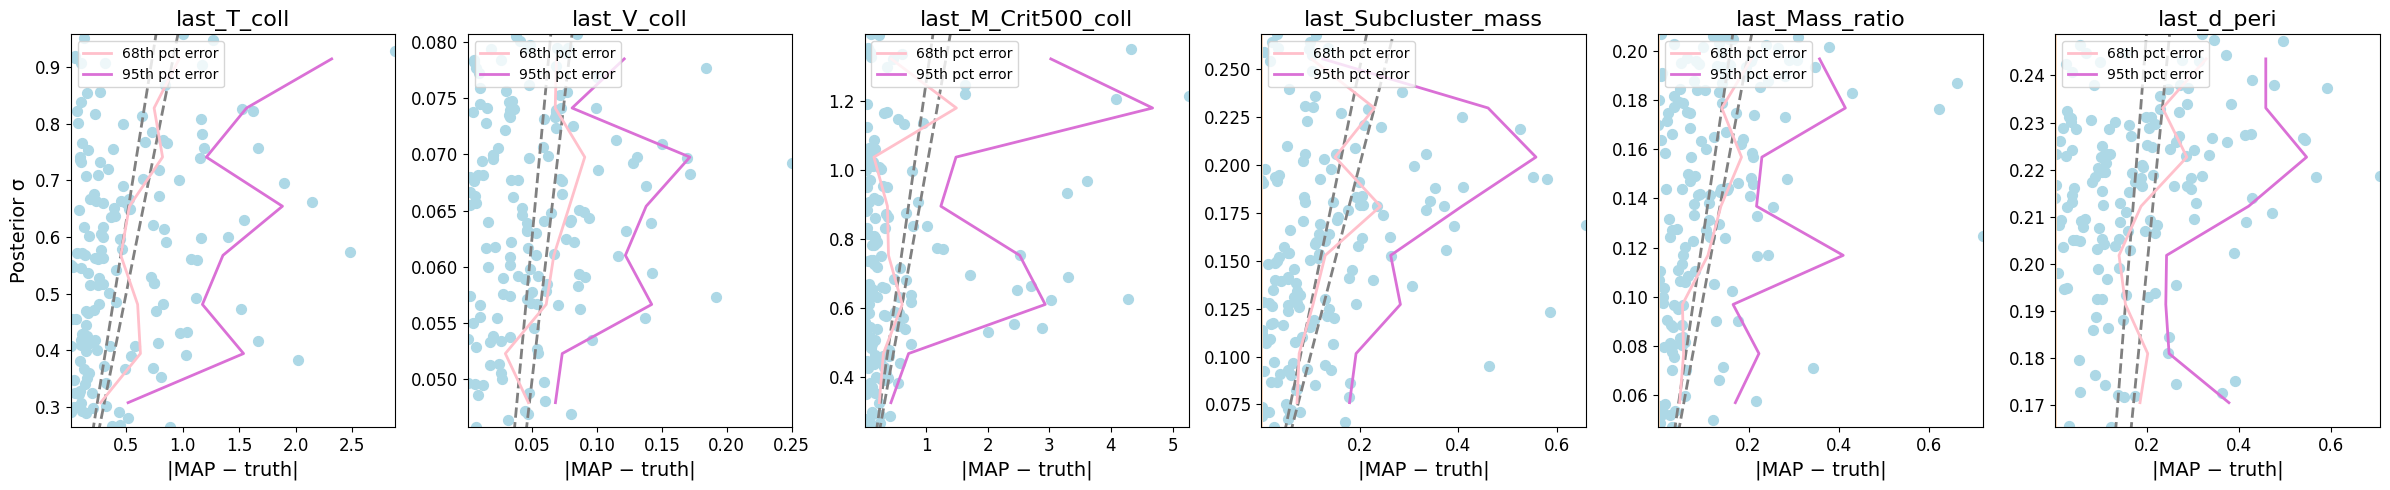

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
import yaml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from model import CINN
from plot_utils import sample_posteriors, compute_map_estimates

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_error_vs_std_scatter(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    params_path: str = "params.yaml",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    linthresh_x: float = 0.1,
    linthresh_y: float = 0.05,
    random_state: int = 42
):
    # Load data
    dfX = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values

    # Test split
    idx = np.arange(len(X_full))
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    truth_phys = tar_sc.inverse_transform(Y_test)

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with open(params_path, "r") as f:
        params = yaml.safe_load(f)
    model = CINN(params, torch.tensor(Y_full[:10], dtype=torch.float32), torch.tensor(X_full[:10], dtype=torch.float32)).to(device)
    ckpt = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt["net"])
    model.eval()

    # Sample posteriors
    post_phys = sample_posteriors(model, X_test, tar_sc, n_samples=n_posterior_samples, device=device)
    map_phys = compute_map_estimates(post_phys)
    std_phys = post_phys.std(axis=1)

    # Plot
    D_tar = Y_full.shape[1]
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)

    for d, ax in enumerate(axes[0]):
        std_d = std_phys[:, d]
        err_d = np.abs(map_phys[:, d] - truth_phys[:, d])

        p5, p95 = np.percentile(std_d, [5, 75])
        mask = (std_d >= p5) & (std_d <= p95)
        err_in, std_in = err_d[mask], std_d[mask]

        ax.scatter(err_in, std_in, s=50, alpha=1.0, color='lightblue')

        lims = np.linspace(err_in.min(), err_in.max(), 200)
        ax.plot(lims, lims,                    '--', color='gray', linewidth=2)
        ax.plot(lims, lims * np.sqrt(np.pi/2), '--', color='gray', linewidth=2)

        bin_edges = np.linspace(std_in.min(), std_in.max(), num_bins + 1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        pct68, pct95 = np.empty(num_bins), np.empty(num_bins)

        for i in range(num_bins):
            sel = (std_in >= bin_edges[i]) & (std_in < bin_edges[i+1])
            pct68[i] = np.percentile(err_in[sel], 68) if sel.any() else np.nan
            pct95[i] = np.percentile(err_in[sel], 95) if sel.any() else np.nan

        ax.plot(pct68, bin_centers, '-', color='pink',  linewidth=2, label='68th pct error')
        ax.plot(pct95, bin_centers, '-', color='orchid', linewidth=2, label='95th pct error')

        ax.axvline(0, color='peachpuff', linewidth=2)

        ax.set_xlim(err_in.min(), err_in.max())
        ax.set_ylim(std_in.min(), std_in.max())

        ax.set_title(TARGET_COLS[d], fontsize=16)
        ax.set_xlabel("|MAP − truth|", fontsize=14)
        if d == 0:
            ax.set_ylabel("Posterior σ", fontsize=14)
        ax.legend(fontsize=10, loc='upper left')
        ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.savefig("3.uncertainities.png", dpi=300, bbox_inches='tight')
    #plt.savefig("3.uncertainities.pdf", dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    plot_error_vs_std_scatter(
        model_checkpoint="runs/20250530_211943_no_scaling/model_last.pt",
        processed_dir="processed_data",
        params_path="params.yaml",
        n_posterior_samples=600,
        num_bins=8,
        linthresh_x=0.1,
        linthresh_y=1,
        random_state=42
    )
